## Importações

In [171]:
import gdown
import os
import numpy as np
import json
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import cv2
import math
import subprocess
import matplotlib.image as mpimg
import matplotlib.patches as patches
import os
import ailia

In [172]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Obtendo o Dataset

In [173]:
# Abrindo o arquivo de keypoints
f = open("/content/drive/MyDrive/cc_10/animal_pose/keypoints.json")
keypoints = json.load(f)
f.close()

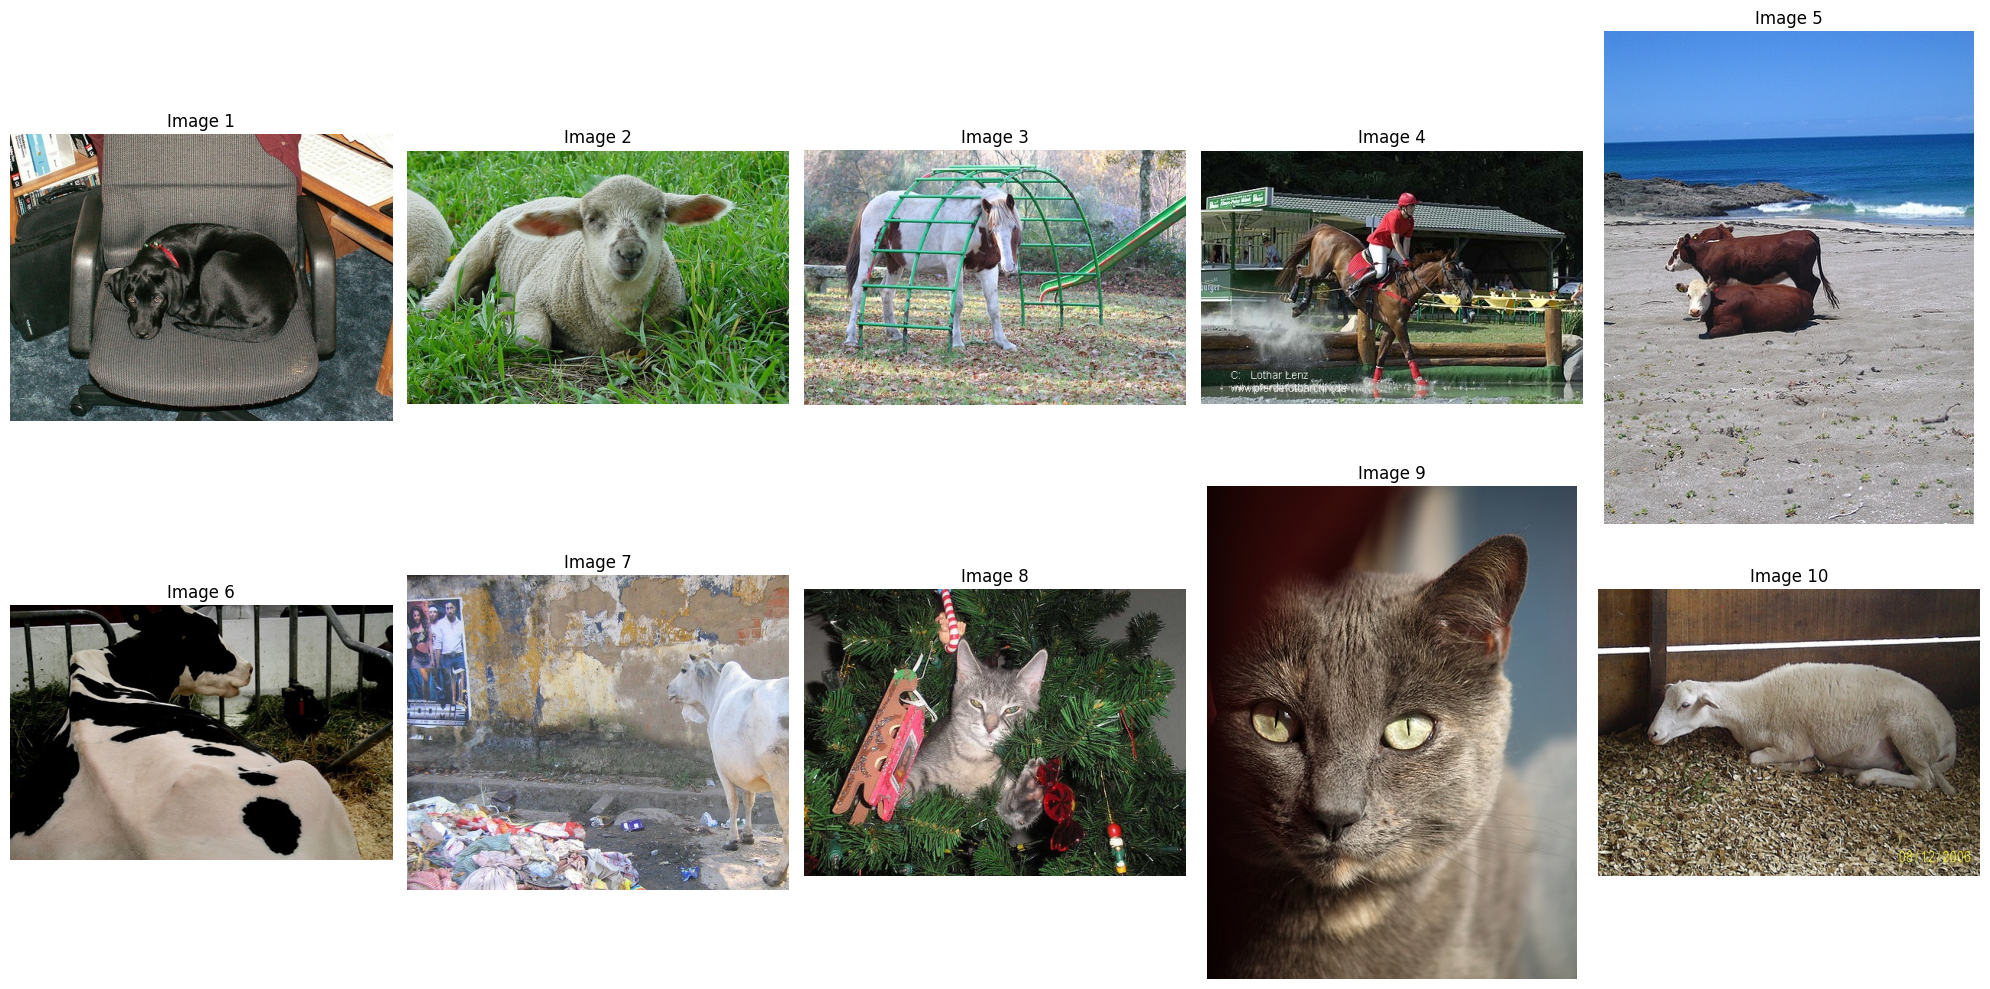

In [174]:
image_directory = "/content/drive/MyDrive/cc_10/animal_pose/images/images/"

# Listar todos os arquivos no diretório
image_files = sorted([f for f in os.listdir(image_directory) if f.endswith('.jpg') or f.endswith('.png')])

# Selecionar as 10 primeiras imagens
image_files = image_files[:10]

# Plotar as imagens
plt.figure(figsize=(20, 10))
for i, image_file in enumerate(image_files):
    img_path = os.path.join(image_directory, image_file)
    img = mpimg.imread(img_path)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f'Image {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


## Tratando/explorando o dataset para identificar os bovinos

In [175]:
# Criando um dicionário de categorias a partir de informações do json
categories = {}
categories_json = keypoints['categories']

for category in categories_json:
  categories[category['id']] = category['name']

categories

{1: 'dog', 2: 'cat', 3: 'sheep', 4: 'horse', 5: 'cow'}

<ipython-input-176-8e72c8ed1e4f>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(categories.values()), y=categories_occ, palette="viridis")


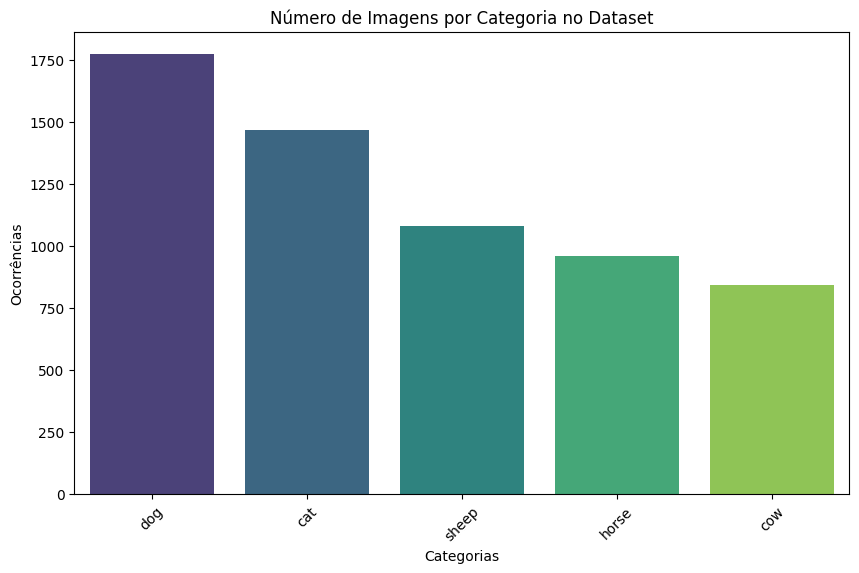

Total de imagens de bovinos: 842.0


In [176]:

import seaborn as sns

# Improved data analysis with better visualization
# Counting the occurrences of each category
categories_occ = np.zeros(len(categories))
for annotation in keypoints['annotations']:
    categories_occ[annotation['category_id'] - 1] += 1

# Plotting the occurrences of each category
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=list(categories.values()), y=categories_occ, palette="viridis")
ax.set_xlabel('Categorias')
ax.set_ylabel('Ocorrências')
ax.set_title('Número de Imagens por Categoria no Dataset')
plt.xticks(rotation=45)
plt.show()

# Highlighting the number of bovine images
print(f"Total de imagens de bovinos: {categories_occ[4]}")


In [177]:
# Calculando a ocorrência de cada categoria
categories_occ = np.zeros(len(categories))

for annotation in keypoints['annotations']:
  categories_occ[annotation['category_id'] - 1] += 1

categories_occ

array([1771., 1466., 1078.,  960.,  842.])

In [178]:
dog_imgs = []
cat_imgs = []
sheep_imgs = []
horse_imgs = []
cow_imgs = []

cow_annotations = {}

for annotation in keypoints['annotations']:
  animal_id = annotation['category_id']
  animal_img_id = str(annotation['image_id'])
  if animal_id == 1:
    dog_img = keypoints['images'][animal_img_id]
    dog_imgs.append(dog_img)
  if animal_id == 2:
    cat_img = keypoints['images'][animal_img_id]
    cat_imgs.append(cat_img)
  if animal_id == 3:
    sheep_img = keypoints['images'][animal_img_id]
    sheep_imgs.append(sheep_img)
  if animal_id == 4:
    horse_img = keypoints['images'][animal_img_id]
    horse_imgs.append(horse_img)
  if animal_id == 5:
    cow_img = keypoints['images'][animal_img_id]
    cow_imgs.append(cow_img)
    cow_annotations[cow_img] = annotation

unique_imgs = np.zeros(len(categories))
unique_imgs[0] = len(np.unique(dog_imgs))
unique_imgs[1] = len(np.unique(cat_imgs))
unique_imgs[2] = len(np.unique(sheep_imgs))
unique_imgs[3] = len(np.unique(horse_imgs))
unique_imgs[4] = len(np.unique(cow_imgs))

In [179]:
root_dir = "/content/drive/MyDrive/cc_10/animal_pose/images/images/"
dimensions = []
dimensions_count = []

for i in range(len(keypoints['images'])):
  image = keypoints['images'][str(i + 1)]
  img = Image.open(root_dir + image)
  width, height = img.size
  dimension = f"{width}x{height}"

  if dimension in dimensions:
      id = dimensions.index(dimension)
      dimensions_count[id] += 1
  else:
      dimensions.append(dimension)
      dimensions_count.append(1)

print(dimensions)
print(dimensions_count)

['500x375', '500x332', '500x333', '375x500', '500x334', '500x412', '480x437', '500x441', '318x480', '500x353', '500x328', '387x500', '429x500', '333x500', '480x398', '275x315', '500x500', '500x340', '500x397', '500x324', '458x500', '368x500', '329x500', '454x500', '320x212', '480x423', '360x500', '417x500', '500x384', '372x500', '500x442', '500x314', '500x376', '500x358', '457x500', '354x500', '264x499', '500x315', '494x500', '500x281', '500x446', '480x318', '500x389', '400x253', '500x374', '480x360', '500x388', '480x367', '500x322', '500x402', '500x349', '299x500', '500x345', '334x500', '500x371', '500x344', '443x480', '500x320', '500x316', '480x392', '496x500', '182x250', '500x302', '500x469', '500x269', '378x500', '332x500', '499x500', '500x400', '356x480', '459x500', '500x319', '357x500', '360x270', '500x321', '480x272', '448x336', '493x500', '483x500', '500x351', '500x370', '500x357', '500x466', '486x348', '411x500', '258x500', '500x346', '500x360', '500x292', '500x347', '500x310'

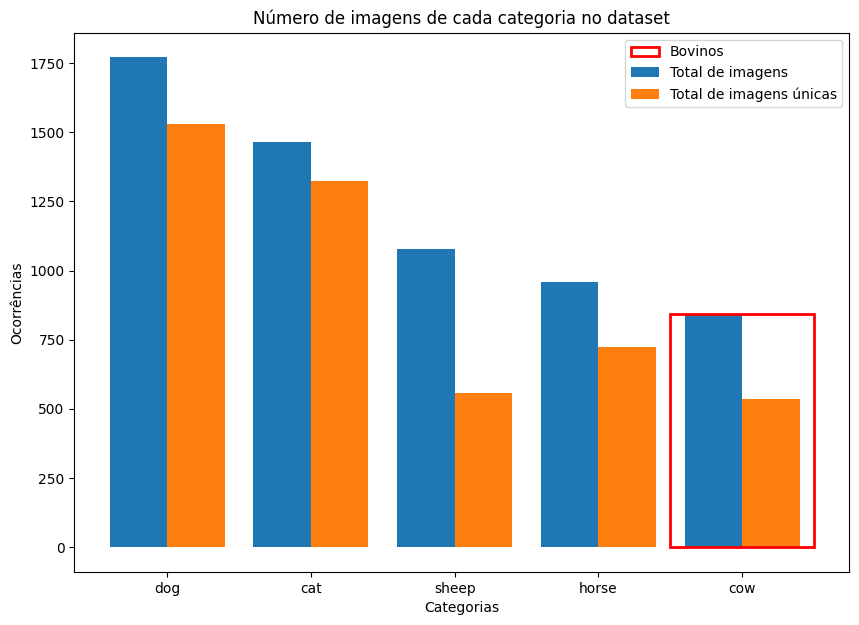

Total de imagens:  6117.0
Total de imagens únicas:  4666.0


Total de imagens de bovinos:  842
Total de imagens únicas de bovinos:  534


In [180]:
# Gráfico de ocorrências
labels = [categories[i+1] for i in range(len(categories))]
values = categories_occ

X_axis = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(10, 7))

bars1 = ax.bar(X_axis - 0.2, values, 0.4, label = 'Total de imagens')
bars2 = ax.bar(X_axis + 0.2, unique_imgs, 0.4, label = 'Total de imagens únicas')

last_cow_idx = len(labels) - 1

bars1_coords = bars1[last_cow_idx].get_bbox()
bars2_coords = bars2[last_cow_idx].get_bbox()

padding = 0.1

# Cria um retângulo em volta das barras de bovinos
bbox = patches.Rectangle((bars1_coords.x0 - padding, min(bars1_coords.y0, bars2_coords.y0) - padding),
                         bars2_coords.x1 - bars1_coords.x0 + 2 * padding,
                         max(bars1_coords.y1, bars2_coords.y1) - min(bars1_coords.y0, bars2_coords.y0) + 2 * padding,
                         linewidth=2, edgecolor='red', facecolor='none', label="Bovinos")

ax.add_patch(bbox)

plt.xticks(X_axis, labels)
plt.xlabel('Categorias')
plt.ylabel('Ocorrências')
plt.title('Número de imagens de cada categoria no dataset')
plt.legend()
plt.show()

print("Total de imagens: ", sum(values))
print("Total de imagens únicas: ", sum(unique_imgs))

print("\n")

print("Total de imagens de bovinos: ", len(cow_imgs))
print("Total de imagens únicas de bovinos: ", len(np.unique(cow_imgs)))

## Tratando as imagens de bovinos

In [181]:
cow_dimensions = []
cow_dimensions_count = []

for i in range(len(cow_imgs)):
  image = cow_imgs[i]
  img = Image.open(root_dir + image)
  width, height = img.size
  dimension = f"{width}x{height}"

  if dimension in cow_dimensions:
      id = cow_dimensions.index(dimension)
      cow_dimensions_count[id] += 1
  else:
      cow_dimensions.append(dimension)
      cow_dimensions_count.append(1)

print(cow_dimensions)
print(cow_dimensions_count)

['375x500', '500x334', '500x412', '500x375', '429x500', '500x397', '500x332', '500x314', '500x376', '500x315', '500x446', '480x360', '500x388', '500x322', '500x324', '500x316', '500x333', '500x351', '500x292', '500x400', '332x500', '500x338', '500x358', '500x206', '500x381', '500x335', '500x396', '448x299', '500x371', '500x336', '347x500', '500x377', '374x500', '474x500', '500x300', '481x500', '500x352', '216x288', '500x330', '500x404', '333x500', '281x500', '334x500', '500x342', '500x370', '500x373', '500x339', '500x272', '500x363', '500x252', '500x365', '500x357', '500x500', '326x500', '441x500', '362x500', '500x407', '500x308', '500x340', '500x244', '500x405', '500x390', '500x417', '450x338', '500x418', '353x500', '350x500', '500x249', '500x283', '500x361', '500x420', '432x463', '370x500', '500x274', '500x281', '500x356', '500x364', '257x171', '500x273', '500x355', '500x327', '500x378', '500x306', '448x336', '500x309', '500x354', '500x389', '500x331', '500x374', '500x208', '300x225'

In [182]:
def load_image_and_annotations(image_path, annotations):

    image = cv2.imread(image_path)
    annotation = annotations[os.path.basename(image_path)]
    keypoints = annotation['keypoints']
    return image, keypoints

In [183]:
def resize_image(image, keypoints):

    h, w, _ = image.shape
    if h < w:
        new_w = DESIRED_WIDTH
        new_h = math.floor(h * DESIRED_WIDTH / w)
    else:
        new_h = DESIRED_HEIGHT
        new_w = math.floor(w * DESIRED_HEIGHT / h)

    scale_x = new_w / w
    scale_y = new_h / h
    image_resized = cv2.resize(image, (new_w, new_h))

    keypoints_resized = []
    for point in keypoints:
        x, y, v = point
        x_new = x * scale_x
        y_new = y * scale_y
        keypoints_resized.append([x_new, y_new, v])

    return image_resized, keypoints_resized

In [184]:
def normalize_image(image):

    image_normalized = image / 255.0
    return image_normalized

In [185]:
def visualize_image(image, keypoints):

    image_uint8 = (image * 255).astype(np.uint8)
    plt.imshow(cv2.cvtColor(image_uint8, cv2.COLOR_BGR2GRAY))
    for point in keypoints:
        x, y, v = point
        if v > 0:  # Apenas visualize pontos válidos
            plt.scatter(x, y, c='green', marker='*')
    plt.show()

In [186]:
def augment_image(image, keypoints):

    h, w, _ = image.shape
    center = (w // 2, h // 2)
    matrix = cv2.getRotationMatrix2D(center, 45, 1.0)
    image_rotated = cv2.warpAffine(image, matrix, (w, h))

    keypoints_rotated = []
    for point in keypoints:
        x, y, v = point
        x_new = matrix[0, 0] * x + matrix[0, 1] * y + matrix[0, 2]
        y_new = matrix[1, 0] * x + matrix[1, 1] * y + matrix[1, 2]
        keypoints_rotated.append([x_new, y_new, v])

    return image_rotated, keypoints_rotated

In [187]:
def detect_edges(image):

    edges = cv2.Canny(image, 100, 200)
    return edges

In [188]:
def find_contours(image):

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour_image = image.copy()
    cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 3)
    return contour_image

In [189]:
def apply_blur(image):

    blurred = cv2.GaussianBlur(image, (15, 15), 0)
    return blurred

In [190]:
def create_processing_figure(original, normalized, augmented, edge_detected, contours, blurred, original_ann, augmented_ann):
    fig, axs = plt.subplots(1, 6, figsize=(25, 5))

    axs[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    axs[0].set_title(f'Original\n{original.shape}')
    for point in original_ann:
        x, y, v = point
        if v > 0:
            axs[0].scatter(x, y, c='green', marker='*')

    augmented_uint8 = (augmented * 255).astype(np.uint8)
    axs[1].imshow(cv2.cvtColor(augmented_uint8, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Augmented')
    for point in augmented_ann:
        x, y, v = point
        if v > 0:
            axs[1].scatter(x, y, c='green', marker='*')

    normalized_uint8 = (normalized * 255).astype(np.uint8)
    axs[2].imshow(normalized_uint8)
    axs[2].set_title('Normalized')

    axs[3].imshow(edge_detected, cmap='gray')
    axs[3].set_title('Edges')

    axs[4].imshow(cv2.cvtColor(contours, cv2.COLOR_BGR2RGB))
    axs[4].set_title('Contours')

    axs[5].imshow(cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB))
    axs[5].set_title('Blurred')

    plt.show()


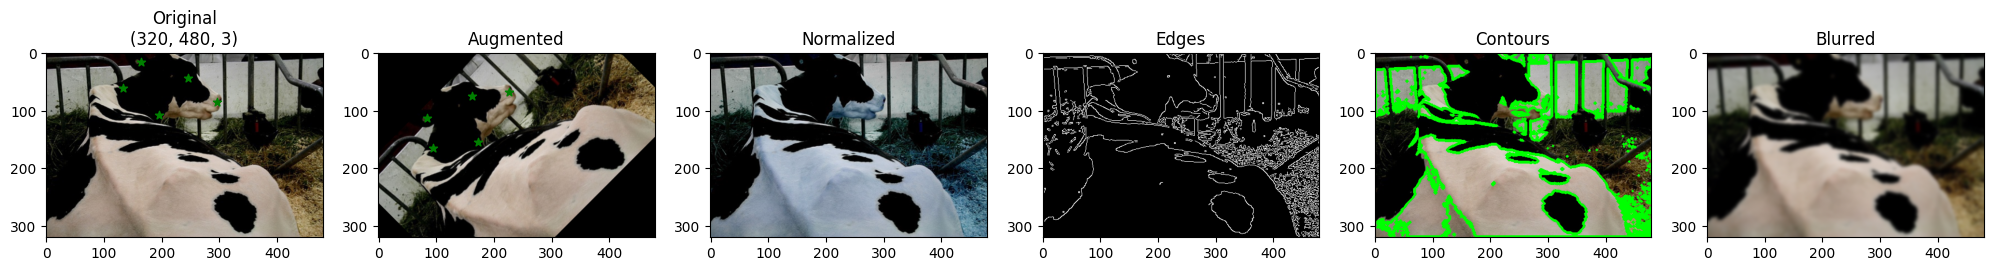

In [191]:
DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480

images_list = []
keypoints_list = []
types_list = []
added_imgs_list = []
dimensions_list = []

unique_images = np.unique(cow_imgs)

counter = 0
for i, img in enumerate(unique_images):
    image_file = img
    annotation_file = cow_annotations[image_file]

    # Carregando imagem e anotações
    image, keypoints = load_image_and_annotations(root_dir + image_file, cow_annotations)

    image_resized, keypoints_resized = resize_image(image, keypoints)
    image_normalized = normalize_image(image_resized)
    image_augmented, keypoints_augmented = augment_image(image_normalized, keypoints_resized)
    edges = detect_edges(image_resized)
    contours = find_contours(image_resized)
    blurred = apply_blur(image_resized)

    images_list.append(image_resized / 255)
    keypoints_list.append(keypoints_resized)
    types_list.append('resized')
    added_imgs_list.append(img)
    dimensions_list.append(image_resized.shape[:2])

    images_list.append(image_augmented)
    keypoints_list.append(keypoints_augmented)
    types_list.append('augmented')
    added_imgs_list.append(img)
    dimensions_list.append(image_augmented.shape[:2])

    # Criação da figura ilustrativa do processo com a próxima imagem
    if i + 1 < len(unique_images):
        next_image_file = unique_images[i + 1]
        next_image, next_keypoints = load_image_and_annotations(root_dir + next_image_file, cow_annotations)
        next_image_resized, next_keypoints_resized = resize_image(next_image, next_keypoints)
        next_image_normalized = normalize_image(next_image_resized)
        next_image_augmented, next_keypoints_augmented = augment_image(next_image_normalized, next_keypoints_resized)
        next_edges = detect_edges(next_image_resized)
        next_contours = find_contours(next_image_resized)
        next_blurred = apply_blur(next_image_resized)

        if counter < 1:
            create_processing_figure(next_image_resized, next_image_normalized, next_image_augmented, next_edges, next_contours, next_blurred, next_keypoints_resized, next_keypoints_augmented)

    counter += 1


In [192]:
# Criando o DataFrame
df = pd.DataFrame({
    'image_name': added_imgs_list,
    'image': images_list,
    'keypoints': keypoints_list,
    'type': types_list,
    'dimensions': dimensions_list
})

# Exibindo o DataFrame
df

image_name                                              image  \
0     2007_000464.jpg  [[[0.8666666666666667, 0.5254901960784314, 0.2...   
1     2007_000464.jpg  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
2     2007_000491.jpg  [[[0.0196078431372549, 0.00784313725490196, 0....   
3     2007_000491.jpg  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
4     2007_000504.jpg  [[[0.1568627450980392, 0.1843137254901961, 0.1...   
...               ...                                                ...   
1063        co97.jpeg  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
1064        co98.jpeg  [[[0.8941176470588236, 0.9490196078431372, 0.9...   
1065        co98.jpeg  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
1066        co99.jpeg  [[[0.9294117647058824, 0.7843137254901961, 0.6...   
1067        co99.jpeg  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   

                                              keypoints       type  dimensions  
0     [[70.08, 216.0, 1], [0.0, 0.0, 0], [61.44, 230...    resized  (480, 360)  
1     [[85.30425986349755, 300.7546146395482, 1], [-...  augmented  (480, 360)  
2     [[0.0, 0.0, 0], [244.79999999999998, 44.071856...    resized  (320, 480)  
3     [[-42.842712474619006, 216.56854249492378, 0],...  augmented  (320, 480)  
4     [[348.47999999999996, 119.84223300970874, 1], ...    resized  (395, 480)  
...                                                 ...        ...         ...  
1063  [[228.68629150101526, 28.760981411776754, 1], ...  augmented  (320, 480)  
1064  [[75.2, 67.15254237288136, 1], [0.0, 0.0, 0], ...    resized  (283, 480)  
1065  [[71.25076439893515, 205.3131594780212, 1], [-...  augmented  (283, 480)  
1066  [[132.8, 155.20000000000002, 1], [96.0, 155.20...    resized  (480, 480)  
1067  [[104.23549801218289, 255.83919189857866, 1], ...  augmented  (480, 480)  

[1068 rows x 5 columns]

In [193]:
!rm -r -f /content/bovinos_images

In [194]:
destination_dir = '/content/bovinos_images'
os.makedirs(destination_dir, exist_ok=True)

# Função para salvar as imagens do DataFrame em outro diretório
def save_images_from_dataframe(df, destination_dir):
    for idx, row in df.iterrows():
        if row['type'] == 'resized':
          image = row['image'] * 255
          image_name = row['image_name']
          destination_path = os.path.join(destination_dir, image_name)
          # Salvar a imagem
          cv2.imwrite(destination_path, image)
          print(f'Saved {image_name} to {destination_path}')

# Salvar as imagens do DataFrame
save_images_from_dataframe(df, destination_dir)

Saved 2007_000464.jpg to /content/bovinos_images/2007_000464.jpg
Saved 2007_000491.jpg to /content/bovinos_images/2007_000491.jpg
Saved 2007_000504.jpg to /content/bovinos_images/2007_000504.jpg
Saved 2007_000904.jpg to /content/bovinos_images/2007_000904.jpg
Saved 2007_001073.jpg to /content/bovinos_images/2007_001073.jpg
Saved 2007_001299.jpg to /content/bovinos_images/2007_001299.jpg
Saved 2007_001764.jpg to /content/bovinos_images/2007_001764.jpg
Saved 2007_001917.jpg to /content/bovinos_images/2007_001917.jpg
Saved 2007_002088.jpg to /content/bovinos_images/2007_002088.jpg
Saved 2007_002387.jpg to /content/bovinos_images/2007_002387.jpg
Saved 2007_002669.jpg to /content/bovinos_images/2007_002669.jpg
Saved 2007_002789.jpg to /content/bovinos_images/2007_002789.jpg
Saved 2007_002903.jpg to /content/bovinos_images/2007_002903.jpg
Saved 2007_003201.jpg to /content/bovinos_images/2007_003201.jpg
Saved 2007_003841.jpg to /content/bovinos_images/2007_003841.jpg
Saved 2007_004081.jpg to 

In [195]:
print(len(cow_dimensions))


169


## Pose Estimation

In [196]:
!rm -f -r util
!rm -f animalpose.py
!rm -f animalpose_utils.py

In [197]:
!pip install ailia

In [198]:
model_dir = "animalpose_model"
os.makedirs(model_dir, exist_ok=True)

# Donwload do modelo de animal pose estimation da Ailia
!wget -q https://storage.googleapis.com/ailia-models/animalpose/hrnet_w32_256x256.onnx -O {model_dir}/hrnet_w32_256x256.onnx
!wget -q https://storage.googleapis.com/ailia-models/animalpose/hrnet_w32_256x256.onnx.prototxt -O {model_dir}/hrnet_w32_256x256.onnx.prototxt

# Download do arquivo principal
!wget -q https://raw.githubusercontent.com/axinc-ai/ailia-models/master/pose_estimation/animalpose/animalpose.py
!wget -q https://raw.githubusercontent.com/axinc-ai/ailia-models/master/pose_estimation/animalpose/animalpose_utils.py

# Download de arquivos utilitários
os.makedirs('util', exist_ok=True)

!wget -q https://raw.githubusercontent.com/axinc-ai/ailia-models/master/util/arg_utils.py -O util/arg_utils.py
!wget -q https://raw.githubusercontent.com/axinc-ai/ailia-models/master/util/model_utils.py -O util/model_utils.py
!wget -q https://raw.githubusercontent.com/axinc-ai/ailia-models/master/util/image_utils.py -O util/image_utils.py
!wget -q https://raw.githubusercontent.com/axinc-ai/ailia-models/master/util/detector_utils.py -O util/detector_utils.py
!wget -q https://raw.githubusercontent.com/axinc-ai/ailia-models/master/util/webcamera_utils.py -O util/webcamera_utils.py
!wget -q https://raw.githubusercontent.com/axinc-ai/ailia-models/master/util/params.py -O util/params.py
!wget -q https://raw.githubusercontent.com/axinc-ai/ailia-models/master/util/log_init.py -O util/log_init.py

In [199]:
def predict_pose(image_path):

    print(image_path)
    !rm -f animalpose_modified.py
    !rm -f hrnet_w32_256x256.onnx
    !rm -f hrnet_w32_256x256.onnx.prototxt
    !rm -f output_result.png
    !rm -f yolov3.opt2.onnx
    !rm -f yolov3.opt2.onnx.prototxt

    with open('animalpose.py', 'r') as file:
        script_content = file.read()

    # Modificar o script para usar a imagem de entrada e salvar a imagem de saída
    script_content = script_content.replace('input.jpg', image_path).replace('output.png', 'output_result.png')

    # Adicionar informações de debug para verificar se a imagem é lida corretamente
    script_content = script_content.replace(
        "IMAGE_PATH = args.input",
        f"IMAGE_PATH = '{image_path}'\nprint('Using image:', IMAGE_PATH)"
    )

    # Garantir que o script possa encontrar os arquivos util
    script_content = script_content.replace("sys.path.append('../../util')", "sys.path.append('./util')")

    with open('animalpose_modified.py', 'w') as file:
        file.write(script_content)

    # Executa o script modificado
    result = subprocess.run(['python3', 'animalpose_modified.py'], capture_output=True, text=True)

    # Checar se a imagem de saída foi salva corretamente
    if os.path.exists('output_result.png'):
        output_image = cv2.imread('output_result.png')
        output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

        # Display da imagem com os keypoints
        plt.imshow(output_image)
        plt.axis('off')
        plt.show()
    else:
        print("Output image not found. Check the script for errors.")

/content/bovinos_images/2007_000464.jpg


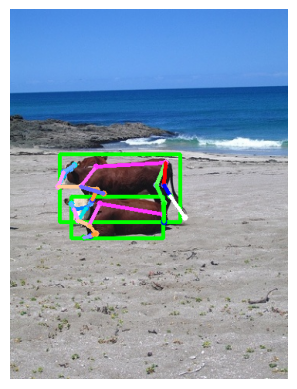

In [200]:
image_dir = "/content/bovinos_images/"
predict_pose(image_dir + df['image_name'].iloc[0])

/content/bovinos_images/2008_005105.jpg


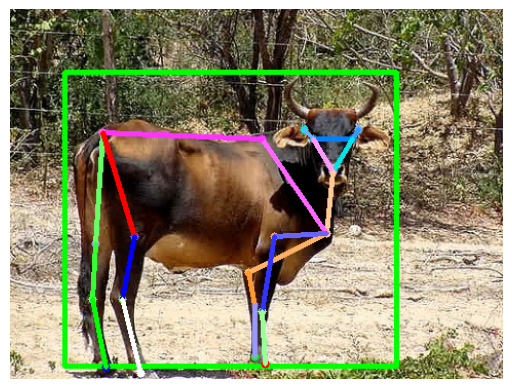

/content/bovinos_images/co10.jpeg


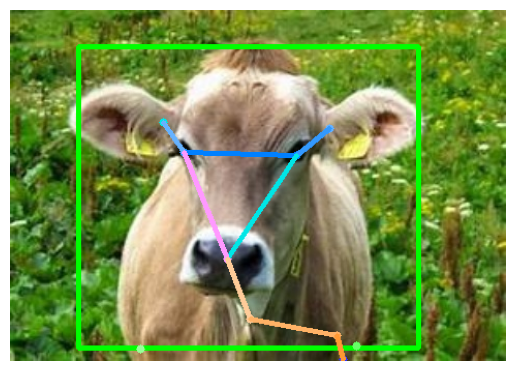

/content/bovinos_images/co123.jpeg


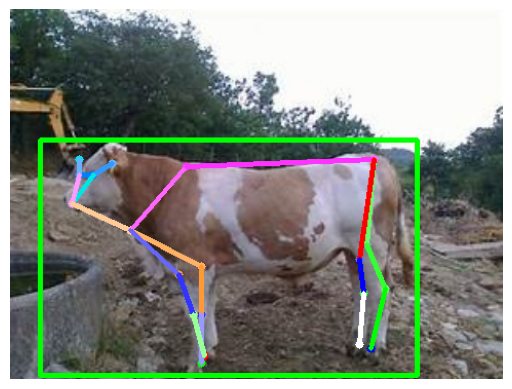

/content/bovinos_images/2008_000009.jpg


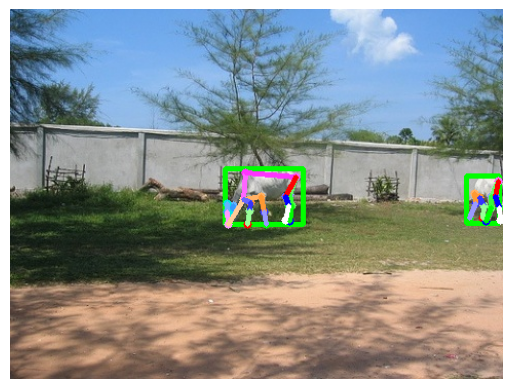

/content/bovinos_images/co87.jpeg


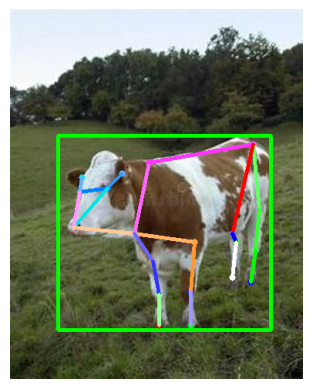

/content/bovinos_images/2008_007031.jpg


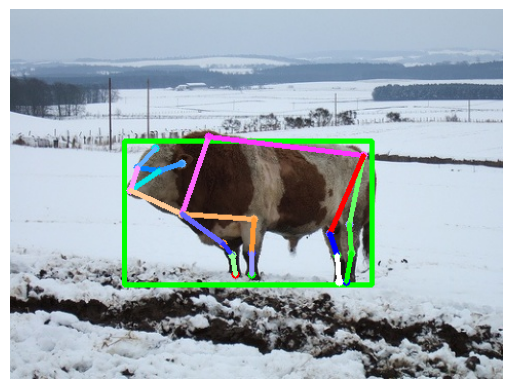

/content/bovinos_images/2009_002221.jpg


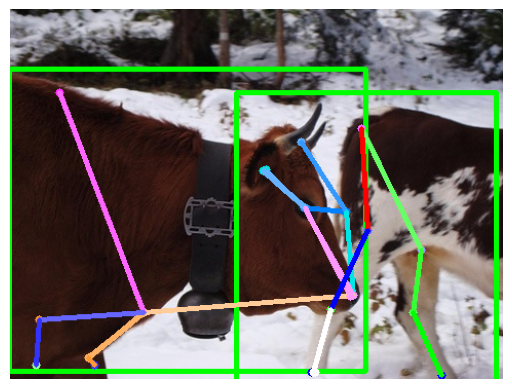

/content/bovinos_images/2011_001653.jpg


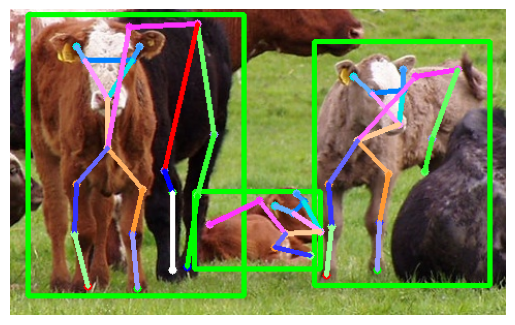

/content/bovinos_images/2010_005166.jpg


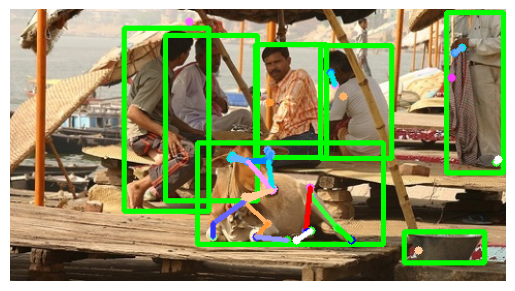

/content/bovinos_images/co52.jpeg


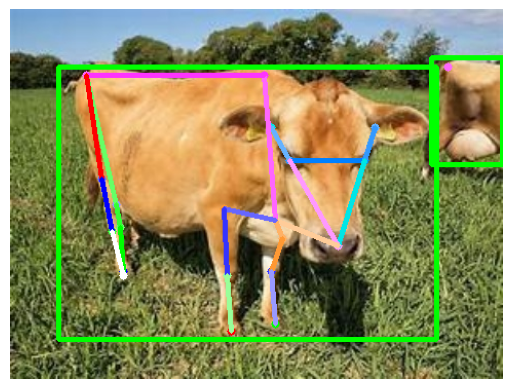

In [201]:
image_dir = "/content/bovinos_images/"

# Predição de 5 imagens
for root, dirs, files in os.walk(image_dir):
  for i in range(0, 10):
    predict_pose(image_dir + files[i])